# Image I/O and manipulation

This how-to guide covers the visualization and manipulation of images with `Bitmap`.
To get started, we import the `mitsuba` library and set a variant.

In [1]:
import mitsuba as mi

mi.set_variant('scalar_rgb')

## Reading an image from disk

Mitsuba provides a general-purpose class for reading, manipulating and writing images: [<code>Bitmap</code>][1]. `Bitmap` can load PNG, JPEG, BMP, TGA, as well as OpenEXR files, and it supports writing PNG, JPEG and OpenEXR files. For PNG and OpenEXR files, it can also write string-valued metadata, as well as the gamma setting.

Mitsuba makes it easy to load images from disk:

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#bitmap

In [2]:
bmp = mi.Bitmap('../scenes/textures/flower_photo.jpeg')

The string representation of the Bitmap class can be used to get more detailed information about the loaded image.

In [3]:
print(bmp)

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma
    uint8 G; // @1, normalized, gamma
    uint8 B; // @2, normalized, gamma
  ],
  data = [ 6.44 MiB of image data ]
]


Let's break down those different pieces of information:

- **Pixel format**:
Specifies the pixel format (e.g. `RGBA` or `MultiChannel`) that contains information about the number and order of channels.

- **Size**:
Resolution of the image.

- **Component format**:
Specifies how the per-pixel components are encoded (e.g. unsigned 8-bit integers or 32-bit floating point values). 

- **sRGB gamma correction**:
Indicates whether the gamma correction (sRGB ramp) is applied to the data.

- **Internal structure**:
Describes the contents of the bitmap, its channels with names and format. For each channel, it also shows if [premultiplied alpha][1] is used.

    
By default, images loaded from PNG or JPEG will be treated as gamma corrected. This is not true for EXR images, so it is important to convert them with the [<code>convert()</code>][2] method if needed.

Different dedicated methods can be used to get and set various attributes, such as [<code>srgb_gamma()</code>][3] and [<code>set_srgb_gamma()</code>][4]. It is important to note that these methods won't change the stored values. They only change how the `Bitmap` is interpreted later on.

For convenience, in Jupyter notebooks, the `Bitmap` type will automatically be displayed when used as the cell output as shown here:

[1]: https://en.wikipedia.org/wiki/Alpha_compositing
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.convert
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.srgb_gamma
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.set_srgb_gamma


In [4]:
bmp

Bitmap[
  pixel_format = rgb,
  component_format = uint8,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<3>[
    uint8 R; // @0, normalized, gamma
    uint8 G; // @1, normalized, gamma
    uint8 B; // @2, normalized, gamma
  ],
  data = [ 6.44 MiB of image data ]
]

## Bitmap conversion

Once the `Bitmap` attributes are properly set, it is possible to convert the image data between different representations. For instance, one might be interested in translating a `UInt8` sRGB bitmap to a linear XYZ bitmap based on half-, single- or double-precision floating point-backed storage.

**Supported pixel formats**:

- `Y`: Single-channel luminance bitmap
- `YA`: Two-channel luminance + alpha bitmap
- `RGB`: RGB bitmap
- `RGBA`: RGB bitmap + alpha channel
- `RGBW`: RGB bitmap + weight (used by [<code>ImageBlock</code>][1])
- `RGBAW`: RGB bitmap + alpha channel + weight (used by `ImageBlock`)
- `XYZ`: XYZ tristimulus bitmap
- `XYZA`: XYZ tristimulus + alpha channel

**Supported component formats**:
`UInt8`, `Int8`, `UInt16`, `Int16`, `UInt32`, `Int32`, `UInt64`, `Int64`, `Float16`, `Float32`, `Float64`


This can be achieved using the [<code>convert()</code>][2] method. All arguments for this method are optional. If no argument is specified, the flags of the source `Bitmap` will be used.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#imageblock
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.convert

In [5]:
bmp = bmp.convert(
    pixel_format=mi.Bitmap.PixelFormat.RGB, 
    component_format=mi.Struct.Type.Float32, 
    srgb_gamma=True
)

print(bmp)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma
    float32 G; // @4, gamma
    float32 B; // @8, gamma
  ],
  data = [ 25.7 MiB of image data ]
]


## Metadata

The `Bitmap` class can also store string-valued metadata with the [<code>metadata()</code>][1] method. This is especially useful when working with the OpenEXR file format as metadata can be directly loaded from or stored to the file.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.metadata

In [6]:
bmp.metadata()['test'] = 'foo'
bmp.metadata()['bar'] = 4.0

print(bmp)

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma
    float32 G; // @4, gamma
    float32 B; // @8, gamma
  ],
  metadata = {
    bar => 4,
    test => "foo"
  },
  data = [ 25.7 MiB of image data ]
]


## Array interface

Thanks to the implementation of [array interface][1], it is possible to use `Bitmap` directly with other Python libraries. For instance, we can visualize an image in this notebook, where `Bitmap` interacts seamlessly with `matplotlib`.

[1]: https://numpy.org/doc/stable/reference/arrays.interface.html

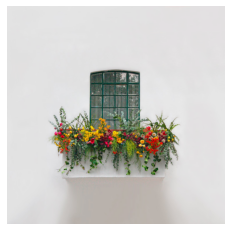

In [7]:
import matplotlib.pyplot as plt

plt.imshow(bmp); plt.axis('off');

More importantly, it is also possible to convert a `Bitmap` object into a NumPy array, or the other way around.

In [8]:
import numpy as np

# Seamless convertion Bitmap -> np.ndarray
bmp_np = np.array(bmp)
type(bmp_np), bmp_np.dtype, bmp_np.shape

(numpy.ndarray, dtype('float32'), (1500, 1500, 3))

Bitmap[
  pixel_format = y,
  component_format = float64,
  size = [100, 100],
  srgb_gamma = 0,
  struct = Struct<8>[
    float64 Y; // @0, premultiplied alpha
  ],
  data = [ 78.1 KiB of image data ]
]


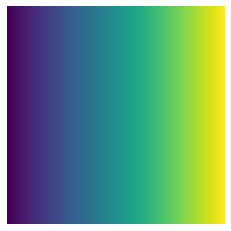

In [9]:
# It is also possible to create a Bitmap object from a numpy array
bmp_np = mi.Bitmap(np.tile(np.linspace(0, 1, 100), (100, 1)))

plt.imshow(bmp_np); plt.axis('off');

print(bmp_np)

## Multichannel images

The `Bitmap` class is especially useful to work with multichannel image formats such as OpenEXR. Such images can also be loaded and manipulated in Python. Here we load an OpenEXR image with $14$ channels (depth, shading normals, position, etc) as the output of our [<code>aov</code>][1] integrator.

[1]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#arbitrary-output-variables-integrator-aov

In [10]:
bmp_exr = mi.Bitmap('../scenes/textures/multi_channels.exr')

print(bmp_exr)

Bitmap[
  pixel_format = multichannel,
  component_format = float32,
  size = [256, 256],
  srgb_gamma = 0,
  struct = Struct<56>[
    float32 R; // @0, premultiplied alpha
    float32 G; // @4, premultiplied alpha
    float32 B; // @8, premultiplied alpha
    float32 depth.T; // @12, premultiplied alpha
    float32 image.R; // @16, premultiplied alpha
    float32 image.G; // @20, premultiplied alpha
    float32 image.B; // @24, premultiplied alpha
    float32 image.A; // @28, alpha
    float32 position.X; // @32, premultiplied alpha
    float32 position.Y; // @36, premultiplied alpha
    float32 position.Z; // @40, premultiplied alpha
    float32 sh_normal.X; // @44, premultiplied alpha
    float32 sh_normal.Y; // @48, premultiplied alpha
    float32 sh_normal.Z; // @52, premultiplied alpha
  ],
  metadata = {
    generatedBy => "Mitsuba version 3.0.0",
    pixelAspectRatio => 1,
    screenWindowWidth => 1
  },
  data = [ 3.5 MiB of image data ]
]


You can also split the `Bitmap` into multiple `Bitmap`s using the [<code>split</code>][1] method. This will return a list of pairs, with each pair containing the channel name and the corresponding `Bitmap` object.

In the following code, we plot the rendered image as well as the shading normals and depth buffer. Note that the `matplotlib` warnings are expected as we are working with HDR images in this example, where pixel values can be much higher than $1.0$.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.split

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


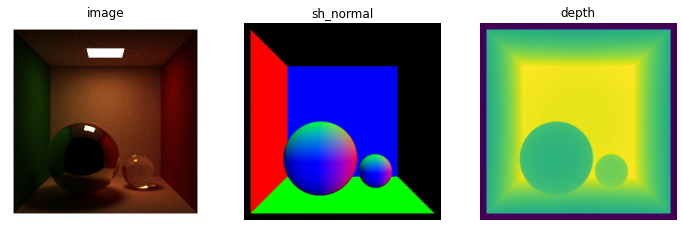

In [11]:
# Here we convert the list of pairs into a dict for easier use
res = dict(bmp_exr.split())

# Plot the image, shading normal and depth buffer
fig, axs = plt.subplots(1, 3, figsize=(12, 4))
axs[0].imshow(res['image']);     axs[0].axis('off'); axs[0].set_title('image');
axs[1].imshow(res['sh_normal']); axs[1].axis('off'); axs[1].set_title('sh_normal');
axs[2].imshow(res['depth']);     axs[2].axis('off'); axs[2].set_title('depth');

When constructing a `Bitmap` with more than 3 channels, it is also possible to provide a list of 
channel names. When `split()` is called, the `Bitmap` class will group channels with the same suffix. Channel names can also be specified in the `aov` integrator.

In [12]:
data = np.zeros((64, 64, 5))

# .. process the data tensor ..

# Construct a bitmap object giving channel names
bmp_multi = mi.Bitmap(data, channel_names=['A.x', 'A.y', 'B.x', 'B.y', 'B.z'])

print(bmp_multi)

Bitmap[
  pixel_format = multichannel,
  component_format = float64,
  size = [64, 64],
  srgb_gamma = 0,
  struct = Struct<40>[
    float64 A.x; // @0, premultiplied alpha
    float64 A.y; // @8, premultiplied alpha
    float64 B.x; // @16, premultiplied alpha
    float64 B.y; // @24, premultiplied alpha
    float64 B.z; // @32, premultiplied alpha
  ],
  data = [ 160 KiB of image data ]
]


## Denoising

The [OptiX AI Denosier][1] is available in `cuda` variants with the [<code>OptixDenoiser</code>][2] class. It can be used to denoise [<code>Bitmap</code>][3] objects or just buffers stored as [<code>TensorXf</code>][4] objects.

The noisy rendered images that are fed to the denoiser must be captured on a [<code>Film</code>][5] with a [<code>box</code>][6] reconstruction filter to produce convincing results. In addition, albedo and shading normal information can be fed to the denoiser to further improve its output. Temporal denoising is also supported, it can drastically improve the consistency of the denoising between subsequent frames.

[1]: https://developer.nvidia.com/optix-denoiser
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.OptixDenoiser
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf
[5]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_films.html
[6]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_rfilters.html#box-filter-box

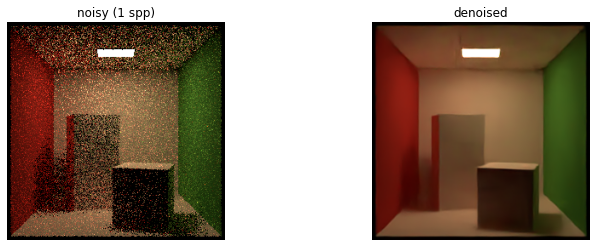

In [13]:
# Set a `cuda` variant
mi.set_variant('cuda_ad_rgb')

# Use the `box` reconstruction filter
scene_description = mi.cornell_box()
scene_description['sensor']['film']['rfilter']['type'] = 'box'
scene = mi.load_dict(scene_description)

noisy = mi.render(scene, spp=1)

# Denoise the rendered image
denoiser = mi.OptixDenoiser(input_size=noisy.shape[:2], albedo=False, normals=False, temporal=False)
denoised = denoiser(noisy)
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
axs[0].imshow(mi.util.convert_to_bitmap(noisy));     axs[0].axis('off'); axs[0].set_title('noisy (1 spp)');
axs[1].imshow(mi.util.convert_to_bitmap(denoised));  axs[1].axis('off'); axs[1].set_title('denoised');

As shown in the example above, all denoiser features must be set during the construction of the [<code>OptixDenoiser</code>][1] and the resolution of the input must also be known. New denoiser objects must be constructed if you wish to handle different input sizes, add albedo information or enable temporal denoising.

Albedo and shading normals can be obtained by using the [<code>aov</code>][2] integrator. For the shading normals, they must be given to the denoiser in the coordinate frame of the sensor. Unfortunately, the [<code>aov</code>][2] integrator writes them to the film in world-space coordinates. Therefore, you  must either transform them on your own or pass the appropriate [<code>Transform4f</code>][3] when calling the denoiser thanks to the `to_sensor` keyword argument.

In the previous cell, `noisy` is a [<code>TensorXf</code>][4] object. Albedo and shading normals could also be [given to the denoiser as tensors][5]. However, it might be more convinient to work with a single multichannel [<code>Bitmap</code>][6] object which holds all buffers: the noisy rendering, the albedo, the shading normals. In that case, the arguments passed to the denoiser are the respective channel names for each layer of supplemental information.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.OptixDenoiser
[2]: https://mitsuba.readthedocs.io/en/latest/src/generated/plugins_integrators.html#arbitrary-output-variables-integrator-aov
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Transform4f
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf
[5]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.OptixDenoiser.__call__
[6]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap

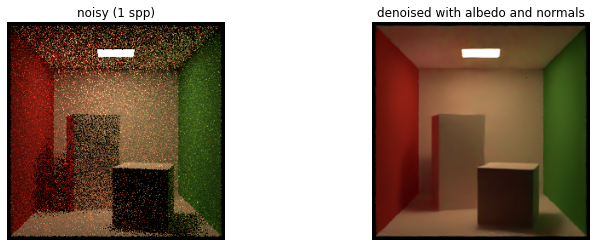

In [14]:
integrator = mi.load_dict({
    'type': 'aov',
    'aovs': 'albedo:albedo,normals:sh_normal',
    'integrator': {
        'type': 'path',
    }
})
sensor = scene.sensors()[0]
to_sensor = sensor.world_transform().inverse()

mi.render(scene, spp=1, integrator=integrator)
noisy_multichannel = sensor.film().bitmap()

# Denoise the rendered image
denoiser = mi.OptixDenoiser(input_size=noisy_multichannel.size(), albedo=True, normals=True, temporal=False)
denoised = denoiser(noisy_multichannel, albedo_ch="albedo", normals_ch="normals", to_sensor=to_sensor)
    
fig, axs = plt.subplots(1, 2, figsize=(12, 4))
noisy = dict(noisy_multichannel.split())['<root>']
axs[0].imshow(mi.util.convert_to_bitmap(noisy));     axs[0].axis('off'); axs[0].set_title('noisy (1 spp)');
axs[1].imshow(mi.util.convert_to_bitmap(denoised));  axs[1].axis('off'); axs[1].set_title('denoised with albedo and normals');

Note the difference in the two denoised images, the one that uses albedo and normals has less artifacts (example: top-left of the emitter).

For temporal denoising, the denoiser must be called with two additional arguments:
1. The optical flow, which indicates the motion of each pixel between the previous and current frames. The flow can be set entirely to zeros and still produce convincing results if the motion between subsequent frame is relatively small.
2. The denoised rendering of the previous frame. For the very first frame, as there is no previous frame, this argument can simply be set to the noisy rendering.

## Resampling an image

Resampling is a common operation in image manipulation, and it is natively supported by the [<code>Bitmap</code>][1] class. For instance this could be used to upscale or downscale an image.

The [<code>resample()</code>][2] method needs the target image resolution.
It also takes an optional [<code>ReconstructionFilter</code>][3] object that is used in the resampling process. By default, a 2-lobe Lanczos filter is used. Note that this `ReconstructionFilter` instance needs to come from the `scalar_rgb` variant of the system. See how the variant is explicitly specified in the code below.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.resample
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.ReconstructionFilter

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [64, 64],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma
    float32 G; // @4, gamma
    float32 B; // @8, gamma
  ],
  metadata = {
    bar => 4,
    test => "foo"
  },
  data = [ 48 KiB of image data ]
]


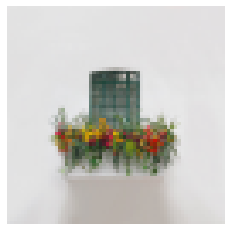

In [15]:
mi.set_variant('scalar_rgb')

rfilter = mi.scalar_rgb.load_dict({'type': 'box'})

bmp_small = bmp.resample([64, 64], rfilter)

plt.imshow(bmp_small); plt.axis('off');
print(bmp_small)

## Writing an image to disk

Writing images to disk is an important operation in a rendering pipeline, and here again, the [<code>Bitmap</code>][1] class has you covered. It provides a blocking routine [<code>write()</code>][2] and an asynchronous routine [<code>write_async()</code>][3].

Note that when writing images to PNG or JPEG, it is necesssary to convert the `Bitmap` object to the `uint8` component format beforehand.

Fortunately, Mitsuba also provides a helper function [<code>mi.util.write_bitmap()</code>][4] to automatically perform the format conversion based on the output file extention. As with the other routines, it can be asynchronous or not, depending on the `write_async` argument (default `True`).

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.write
[3]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap.write_async
[4]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.util.write_bitmap

In [16]:
# Convert image to uint8
bmp_small = bmp_small.convert(mi.Bitmap.PixelFormat.RGB, mi.Struct.Type.UInt8, True)
# Write image to JPEG file
bmp_small.write('../scenes/textures/flower_photo_downscale.jpeg')

# Or equivalently ...

# Use the helper function to achieve the same result
mi.util.write_bitmap('../scenes/textures/flower_photo_downscale.jpeg', bmp_small, write_async=True)

## Arithmetic using  `mi.TensorXf`

Unlike NumPy arrays, the [<code>Bitmap</code>][1] objects aren't meant to be manipulated with arithmetic operations. Moreover, `Bitmap` is not a differentiable type. For such operations Mitsuba provides [<code>TensorXf</code>][2] that behaves analogously to a NumPy array.

Thanks to the array interface protocol, a `TensorXf` can be directly created from a `Bitmap` object, and vice-versa.

[1]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.Bitmap
[2]: https://mitsuba.readthedocs.io/en/latest/src/api_reference.html#mitsuba.TensorXf

In [17]:
# Thanks to the array interface protocol, it is easy to create a TensorXf from a bitmap object
img = mi.TensorXf(bmp)

img

TensorXf(shape=(1500, 1500, 3))

After manipulating the tensorial data, we can put it back into a `Bitmap` object.

When creating a `Bitmap` from an array, we assume that the array is **not** gamma corrected. If that is not the case, for example when the tensor data comes from a JPEG image, it is important to manually set the gamma correction flag on the new `Bitmap` object.

Bitmap[
  pixel_format = rgb,
  component_format = float32,
  size = [1500, 1500],
  srgb_gamma = 1,
  struct = Struct<12>[
    float32 R; // @0, gamma, premultiplied alpha
    float32 G; // @4, gamma, premultiplied alpha
    float32 B; // @8, gamma, premultiplied alpha
  ],
  data = [ 25.7 MiB of image data ]
]


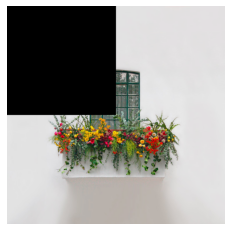

In [18]:
# Some tensorial manipulation (here we blackout the upper left corner of the image)
img[:750, :750, :] = 0.0

# Create a Bitmap from the TensorXf object
bmp_new = mi.Bitmap(img)

# Specify that the underlying data is already gamma corrected
bmp_new.set_srgb_gamma(True)

plt.imshow(bmp_new); plt.axis('off');

print(bmp_new)